In [1]:
import json
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt


In [3]:
# Root that contains per-case folders like cow_220_4, chicken_..., etc.
CASES_ROOT = Path("/home/hschatzle/monte-carlo-selection/data/cases")

# We will look for: CASE/results/planB/certainty_metrics.jsonl
REL_JSONL = Path("results/planB/certainty_metrics.jsonl")

# Discover all case folders.
case_dirs = sorted([p for p in CASES_ROOT.iterdir() if p.is_dir()])

jsonl_paths = []
missing = []
for c in case_dirs:
    p = c / REL_JSONL
    if p.exists():
        jsonl_paths.append(p)
    else:
        missing.append(p)

print(f"Case folders found: {len(case_dirs)}")
print(f"JSONLs found:       {len(jsonl_paths)}")
print(f"Missing JSONLs:     {len(missing)}")
print("Example found:", jsonl_paths[0] if jsonl_paths else None)


Case folders found: 11
JSONLs found:       4
Missing JSONLs:     7
Example found: /home/hschatzle/monte-carlo-selection/data/cases/ant_107/results/planB/certainty_metrics.jsonl


In [3]:
def read_jsonl(path: Path):
    rows = []
    for line in path.read_text(encoding="utf-8").splitlines():
        line = line.strip()
        if not line:
            continue
        rows.append(json.loads(line))
    return rows

all_rows = []
for p in jsonl_paths:
    try:
        rows = read_jsonl(p)
        for r in rows:
            r["_source_jsonl"] = str(p)  # track provenance
        all_rows.extend(rows)
    except Exception as e:
        print(f"Failed reading {p}: {type(e).__name__}: {e}")

print(f"Total rows loaded: {len(all_rows)}")
print("Example keys:", list(all_rows[0].keys()) if all_rows else None)


Total rows loaded: 4
Example keys: ['best_png', 'gt_png', 'best_pred_idx', 'gt_pred_idx', 'best_pred_class', 'gt_pred_class', 'metrics', '_source_jsonl']


In [4]:
# Collect metric keys dynamically from data, but also keep a preferred order if present.
preferred_order = ["margin_top2", "p_top1", "entropy", "energy_logsumexp"]

# Find available metric keys
metric_keys = set()
for r in all_rows:
    m = r.get("metrics", {})
    metric_keys.update(list(m.keys()))

metric_keys = list(metric_keys)

# Sort keys: preferred first, then the rest alphabetically
metric_keys = [k for k in preferred_order if k in metric_keys] + sorted([k for k in metric_keys if k not in preferred_order])

print("Metrics found:", metric_keys)

# Extract numeric arrays
best_by_metric = {k: [] for k in metric_keys}
gt_by_metric   = {k: [] for k in metric_keys}
dlt_by_metric  = {k: [] for k in metric_keys}  # BEST - GT

# Optional: track whether pred classes match
pred_match = []

skipped = 0
for r in all_rows:
    metrics = r.get("metrics", {})
    ok = True
    for k in metric_keys:
        if k not in metrics or "best" not in metrics[k] or "gt" not in metrics[k]:
            ok = False
            break
    if not ok:
        skipped += 1
        continue

    for k in metric_keys:
        b = float(metrics[k]["best"])
        g = float(metrics[k]["gt"])
        best_by_metric[k].append(b)
        gt_by_metric[k].append(g)
        dlt_by_metric[k].append(b - g)

    pred_match.append(r.get("best_pred_class") == r.get("gt_pred_class"))

print(f"Rows used:    {len(pred_match)}")
print(f"Rows skipped: {skipped}")
if pred_match:
    print(f"Pred class match rate: {np.mean(pred_match)*100:.1f}%")


Metrics found: ['margin_top2', 'p_top1', 'entropy', 'energy_logsumexp']
Rows used:    4
Rows skipped: 0
Pred class match rate: 100.0%


In [5]:
def mean_std(x):
    x = np.asarray(x, dtype=float)
    return float(np.mean(x)), float(np.std(x, ddof=1)) if len(x) > 1 else (float(np.mean(x)), 0.0)

print("Summary (mean ± std). BEST, GT, and (BEST - GT):\n")

for k in metric_keys:
    b_mu, b_sd = mean_std(best_by_metric[k])
    g_mu, g_sd = mean_std(gt_by_metric[k])
    d_mu, d_sd = mean_std(dlt_by_metric[k])
    n = len(best_by_metric[k])
    print(f"{k:>16} | n={n:4d} | BEST {b_mu:+.4f} ± {b_sd:.4f} | GT {g_mu:+.4f} ± {g_sd:.4f} | Δ {d_mu:+.4f} ± {d_sd:.4f}")


Summary (mean ± std). BEST, GT, and (BEST - GT):

     margin_top2 | n=   4 | BEST +1.5137 ± 1.4250 | GT +1.5135 ± 1.7099 | Δ +0.0003 ± 0.3555
          p_top1 | n=   4 | BEST +0.5500 ± 0.2419 | GT +0.5234 ± 0.2907 | Δ +0.0266 ± 0.0808
         entropy | n=   4 | BEST +1.4670 ± 0.7048 | GT +1.5119 ± 0.9072 | Δ -0.0450 ± 0.2680
energy_logsumexp | n=   4 | BEST +8.6716 ± 1.4717 | GT +8.7323 ± 1.9877 | Δ -0.0607 ± 0.7475


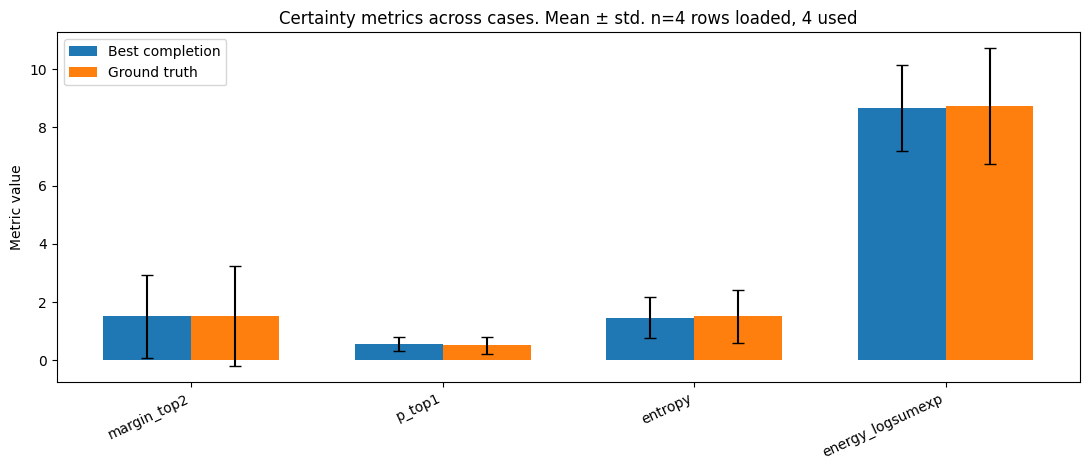

In [6]:
# Prepare data
means_best = []
stds_best  = []
means_gt   = []
stds_gt    = []

for k in metric_keys:
    mu, sd = mean_std(best_by_metric[k])
    means_best.append(mu)
    stds_best.append(sd)

    mu, sd = mean_std(gt_by_metric[k])
    means_gt.append(mu)
    stds_gt.append(sd)

x = np.arange(len(metric_keys))
w = 0.35

plt.figure(figsize=(11, 4.8))

# Bars
plt.bar(x - w/2, means_best, width=w, label="Best completion")
plt.bar(x + w/2, means_gt,   width=w, label="Ground truth")

# Error bars (std)
plt.errorbar(x - w/2, means_best, yerr=stds_best, fmt="none", capsize=4, ecolor="#000000")
plt.errorbar(x + w/2, means_gt,   yerr=stds_gt,   fmt="none", capsize=4, ecolor="#000000")

plt.xticks(x, metric_keys, rotation=25, ha="right")
plt.ylabel("Metric value")
plt.title(f"Certainty metrics across cases. Mean ± std. n={len(all_rows)} rows loaded, {len(pred_match)} used")
plt.legend()
plt.tight_layout()
plt.show()


# Deltas

In [7]:
# --------------------------------------------------
# Standardize paired deltas per metric (Option A)
# --------------------------------------------------

z_by_metric = {}
raw_delta_stats = {}

for k in metric_keys:
    d = np.asarray(dlt_by_metric[k], dtype=float)

    if len(d) < 2:
        print(f"Skipping metric {k}: not enough samples")
        continue

    mu = np.mean(d)
    sd = np.std(d, ddof=1)

    if sd == 0:
        print(f"Skipping metric {k}: zero variance in deltas")
        continue

    z = d / sd  # mean-centering not needed for effect-size interpretation

    z_by_metric[k] = z
    raw_delta_stats[k] = {
        "mean_delta": mu,
        "std_delta": sd,
        "n": len(d)
    }

print("Standardized metrics:", list(z_by_metric.keys()))


Standardized metrics: ['margin_top2', 'p_top1', 'entropy', 'energy_logsumexp']


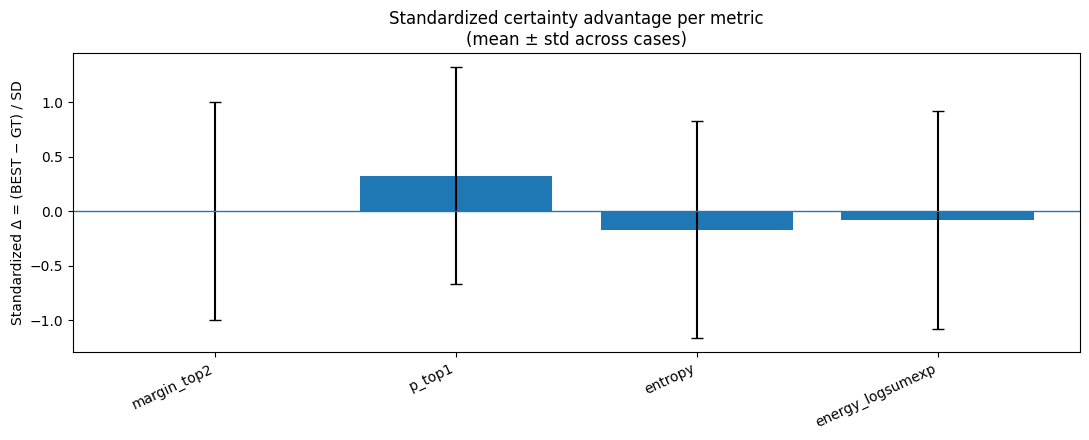

In [8]:
# --------------------------------------------------
# Plot standardized deltas per metric
# --------------------------------------------------

means_z = []
stds_z  = []

for k in metric_keys:
    if k not in z_by_metric:
        means_z.append(np.nan)
        stds_z.append(np.nan)
        continue

    z = z_by_metric[k]
    means_z.append(np.mean(z))
    stds_z.append(np.std(z, ddof=1))

x = np.arange(len(metric_keys))

plt.figure(figsize=(11, 4.5))
plt.bar(x, means_z)
plt.errorbar(x, means_z, yerr=stds_z, fmt="none", capsize=4, ecolor="#000000")
plt.axhline(0, linewidth=1)

plt.xticks(x, metric_keys, rotation=25, ha="right")
plt.ylabel("Standardized Δ = (BEST − GT) / SD")
plt.title("Standardized certainty advantage per metric\n(mean ± std across cases)")
plt.tight_layout()
plt.show()


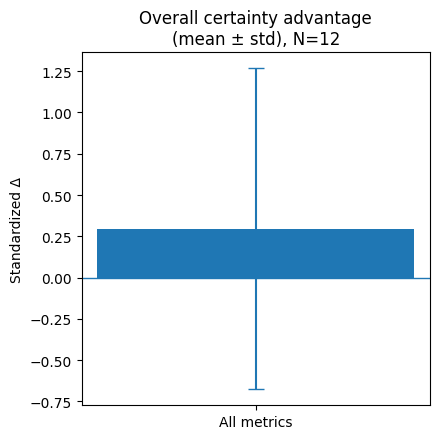

Overall standardized certainty advantage: +0.296 ± 0.972


In [14]:
# --------------------------------------------------
# Combine standardized deltas across metrics
# --------------------------------------------------

# Stack all z-deltas into one vector
all_z = np.concatenate([z_by_metric[k] for k in z_by_metric])

mean_all = np.mean(all_z)
std_all  = np.std(all_z, ddof=1)

plt.figure(figsize=(4.5, 4.5))
plt.bar([0], [mean_all])
plt.errorbar([0], [mean_all], yerr=[std_all], fmt="none", capsize=6)
plt.axhline(0, linewidth=1)

plt.xticks([0], ["All metrics"])
plt.ylabel("Standardized Δ")
plt.title(f"Overall certainty advantage\n(mean ± std), N={len(all_z)}")
plt.tight_layout()
plt.show()

print(f"Overall standardized certainty advantage: {mean_all:+.3f} ± {std_all:.3f}")


In [15]:
print("Metric-wise summary:")
for k in metric_keys:
    if k not in raw_delta_stats:
        continue
    s = raw_delta_stats[k]
    print(
        f"{k:>16} | "
        f"Δ mean = {s['mean_delta']:+.4f}, "
        f"SD = {s['std_delta']:.4f}, "
        f"n = {s['n']}"
    )


Metric-wise summary:
     margin_top2 | Δ mean = +0.1586, SD = 0.1978, n = 3
          p_top1 | Δ mean = +0.0469, SD = 0.0855, n = 3
         entropy | Δ mean = -0.1115, SD = 0.2849, n = 3
energy_logsumexp | Δ mean = +0.1644, SD = 0.7307, n = 3
